In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import altair as alt
from sublimpy import utils
from sublimpy import variables
from sublimpy import tidy
from metpy.units import units
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import scipy.integrate
from scipy.optimize import curve_fit

In [ ]:
fn = "/Users/elischwat/Downloads/250917_for_Eli/230517_120045.nc"

# Open a subset of one large file

In [3]:
ds = xr.open_dataset(fn, chunks="auto")  # Lazily opens the NetCDF file with Dask

# Get a slice so we just do a bit of processing
ds = ds.sel(frame=slice(0, 100)).compute()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/elischwat/Downloads/250917_for_Eli/230517_120045.nc'

In [ ]:
# Let's just use 1 frame
ds_1frame = ds['irdata'].sel(frame=0)

In [ ]:
# the data is "shifted" in the col axis.. we need to chop and concatenate. 
# This col value where the shift happens varies with frame...
# we will only deal with one frame for now.
right_side = ds_1frame.sel(col = slice(0,868))
left_side  = ds_1frame.sel(col = slice(869, 1024))
ds_1frame = xr.concat(
    [left_side, right_side],
    dim='col'
)

# Transpoe and then reverse rows so that it plots in a visually-spatially-correct way
ds_1frame = ds_1frame.T
ds_1frame = ds_1frame[::-1,::]

In [ ]:
# 515 --> 790 --> 480

In [ ]:
ds_1frame.plot(vmin=0,vmax=20, cmap='turbo')
# plt.xlim(400, 600)

find the "ground" - where the left pole "ends"

In [ ]:
ds_1frame.sel(
    row=slice(150,350),
    col=slice(0, 100),
).plot(vmin=0,vmax=20, cmap='turbo', figsize=(3,3))

Looks like its at about row=125. We will grab all data above that 

In [ ]:
ds_1frame_cropped = ds_1frame.sel(row=slice(260,ds_1frame.row.values.max()))

In [ ]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Grab a subset of the data so col starts at and ends at the left and right boundaries of the two sheets.

In [ ]:
# this removes the left most edge
ds_1frame_cropped = ds_1frame_cropped.sel(col=slice(28,1024))

# this removes the right most edge
ds_1frame_cropped = ds_1frame_cropped.sel(col=slice(0, 929))

In [ ]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Now let's cut off the top

In [ ]:
ds_1frame_cropped.sel(
    row = slice(0,340)
).plot(vmin=0,vmax=20, cmap='turbo')

In [ ]:
ds_1frame_cropped = ds_1frame_cropped.sel(
    row = slice(0,340)
)

In [ ]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

# Find the snow-surface and set values below to 0

In [ ]:
ds_1frame_cropped.diff(dim='row').rolling(row=2).median().plot(cmap='turbo')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Get the row index of the maximum value for each column
max_indices = ds_1frame_cropped.diff(dim='row').rolling(row=2).median().argmax(dim="row", skipna=True)

ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')
max_indices.rolling(col=5).median().plot(color='white')
plt.ylim(0,100)

In [ ]:
max_indices = max_indices.rolling(col=5).median()

In [ ]:
ds_1frame_cropped = ds_1frame_cropped.where(ds_1frame_cropped.row > max_indices, other=0)

In [ ]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Remove the data in between the two sheets

In [ ]:
ds_1frame_cropped.sel(
    col = slice(508,555)
).plot(vmin=0,vmax=20, cmap='turbo')

In [ ]:
ds_1frame_cropped = ds_1frame_cropped.where(
    (ds_1frame_cropped.col < 508)
    | (ds_1frame_cropped.col > 555)
)

In [ ]:
ds_1frame_cropped.plot(vmin=0,vmax=15, cmap='turbo')

Convert the row and column indices to meters

Length relations: 
* the fixation of the left horizontal bar at the leftmost vertical bar is at 1.90m above the (bare) surface. 
* The left horizontal bar from vertical post to vertical post is 2.92m long. 
* The right horizontal bar from vertical post to vertical post is 2.06m. The bottom of the right horizontal bar is 2.26m above bare ground at the middle vertical post. Sorry, a lot of numbers...

i.e...
* total width of the col dimension, i.e. from the left edge of left sheet to right edge of right sheet is: 2.06 + 2.92 = **4.98 meters**
* total height of the row dimension, i.e. from where the pole meets the ground to the top support pole, is **1.9 meters**

In [ ]:
TOTAL_WIDTH = 4.98
TOTAL_HEIGHT = 1.9

## FOR THE GRIDDED DATA
# create coords x and why, scaling the col and row dimensions using the dimensions of the observations/sheets
ds_1frame_cropped = ds_1frame_cropped.assign_coords(
    x = TOTAL_WIDTH * ds_1frame_cropped.col / len(ds_1frame_cropped.col),
    z = TOTAL_HEIGHT * ds_1frame_cropped.row / len(ds_1frame_cropped.row)
)

# replace the dims with the physical ones
ds_1frame_cropped = ds_1frame_cropped.to_dataframe().reset_index(drop=True).set_index(['x', 'z']).to_xarray().irdata.T

In [ ]:
ds_1frame_cropped.plot(vmin=0,vmax=15, cmap='turbo')
plt.gca().set_aspect('equal')

### Apply Gaussian Smoothing Filter

In [ ]:
from scipy.ndimage import gaussian_filter

sigma = 3

# Apply the gaussian_filter from SciPy to the DataArray using .apply()
# `keep_attrs=True` will retain the original metadata.
smoothed_da = xr.apply_ufunc(
    gaussian_filter,
    ds_1frame_cropped,
    input_core_dims=[['z', 'x']],
    output_core_dims=[['z', 'x']],
    kwargs={'sigma': sigma},
    dask='parallelized', # Use Dask for parallel computation on large arrays
    output_dtypes=[ds_1frame_cropped.dtype],
    keep_attrs=True,
    dask_gufunc_kwargs={'allow_rechunk': True}
)

In [ ]:
smoothed_da.plot(vmin=0,vmax=15, cmap='turbo')
plt.gca().set_aspect('equal')

In [ ]:
ds_1frame_cropped = smoothed_da

Extract Profiles at 50cm intervals, use 10cm width, 2cm height, bins to get values

In [ ]:
# get a dataframe for easy processing
df = ds_1frame_cropped.to_dataframe().reset_index()

# bin the z values
df = df.assign(
    z = pd.cut(df['z'], np.linspace(-0.02,2,102)).apply(
        lambda interval: interval.right
    )
)

Combine the datasets. Also, reindex into a higher resolution so that we can manipulate the data later.

In [ ]:
z_high_res = np.linspace(0, 2, num=1001)  # Adjust num for desired resolution
z_high_res

Where should we extract profiles? Let's not go beyond x=4, because the way we had to crop the data makes it so there is no snow at the bottom beyond x=4. What about x=0?

In [ ]:
ds_1frame_cropped.sel(x=slice(0,0.10)).plot(vmin=0,vmax=15, cmap='turbo')

We see that data is noisy - let's extract data every 25cm, but make our first data point at 0.01

In [ ]:
X = np.linspace(0.5, 4.0, 8)
X

In [ ]:
df_profiles = pd.DataFrame()
for val in X:
    profile = df.query(
            f"x > {val - 0.05}"
        ).query(
            f"x < {val + 0.05}"
        ).groupby('z', observed=True)[
            ['irdata']
        ].mean(
            
        ).assign(
            x = val
        ).reindex(
            z_high_res
        ).interpolate(
            method='linear'
        )
    df_profiles = pd.concat([df_profiles,profile])

In [ ]:
df_upwind_profiles = pd.DataFrame()
for val in [0.03,0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.30]:
    profile = df.query(
            f"x > {val - 0.005}"
        ).query(
            f"x < {val + 0.005}"
        ).groupby('z', observed=True)[
            ['irdata']
        ].mean(
            
        ).assign(
            x = val
        ).reindex(
            z_high_res
        ).interpolate(
            method='linear'
        )
    df_upwind_profiles = pd.concat([df_upwind_profiles,profile])

In [ ]:
alt.data_transformers.disable_max_rows()

In [ ]:
src = df_profiles.reset_index()
alt.Chart(
    src[~src.x.isin([
        1.2,1.3,1.4
    ])].query("x < 3")
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

In [ ]:
src = df_profiles.reset_index().query("x < 3.5").query("z < .50")
alt.Chart(
    src[~src.x.isin([
        1.2,1.3,1.4
    ])].query("x < 3")
).mark_line(point=True).encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    # alt.Facet('x:O', columns=4),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

I need to adjust the profiles for the variable snow surface. 

Steps:
1. (Optional) Interpolate along the lines to get a higher resolution dataset
2. Find z value where irdata = 0 - actually, it looks like things will work better if I use irdata = 2?
3. Adjust z values for that profile

In [ ]:
adjusted_df_list = []
for val in X:
    src = df_profiles.query(f"x == {val}")
    src.irdata = src.irdata.round(2)
    idx = src['irdata'][::-1].idxmin()
    src.index = src.index - idx + 0
    adjusted_df_list.append(src)
df_adjusted = pd.concat(adjusted_df_list)

In [ ]:
adjusted_df_list = []
for val in df_upwind_profiles.x.unique():
    src = df_upwind_profiles.query(f"x == {val}")
    src.irdata = src.irdata.round(2)
    idx = src['irdata'][::-1].idxmin()
    src.index = src.index - idx + 0
    adjusted_df_list.append(src)
df_upwind_adjusted = pd.concat(adjusted_df_list)

In [ ]:
alt.Chart(
    df_adjusted.reset_index().query("z < 0.14")
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    # alt.Facet('x:O', columns=4),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300) | alt.Chart(
    df_adjusted.reset_index()
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

In [ ]:
alt.Chart(
    df_adjusted[~df_adjusted.x.isin([
        1.2,1.3,1.4
    ])].query("x < 3").reset_index().query("z >= 0")
).mark_line().encode(
    alt.X('irdata:Q').title('T (˚C)'),
    alt.Y('z:Q').title('Height (m)'),
    alt.Color('x:O').scale(scheme='rainbow'),
    order='z:Q',
    tooltip='x'
).properties(width = 200, height = 200)

In [ ]:
alt.Chart(
    df_upwind_adjusted.reset_index().query("z < 0.50").query("z > 0.05")
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    # alt.Facet('x:O', columns=4),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

any of these will work, apart from the profile at x =0.03

Set the internal boundary layer depth - above that height, we will not calculate advected energy

We manually select this based on the "blending height" we observe above

In [ ]:
MAX_INTEGRATION_DEPTH = 0.6

# Calculate sensible heat flux into snow

Open sos data 

In [4]:
sos_tidy_fn = f"../../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet"
sos_df = pd.read_parquet(sos_tidy_fn)
sos_df['time'] = pd.to_datetime(sos_df['time'])
sos_df = utils.modify_df_timezone(sos_df, 'UTC', 'US/Mountain')

In [5]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [6]:
alt.Chart(
    sos_df[sos_df.measurement  == 'w'].set_index(
        'time'
    ).sort_index().loc['20230509':'20230522'].reset_index().query("height >= 1")
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-3,3],
    groupby=['tower','height']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('rolling_avg:Q'),
    alt.Facet('tower:N', columns=1),
    alt.Color('height:N')
).resolve_scale(y='independent').properties(width=1000, height=150)


alt.Chart(...)

In [7]:
alt.Chart(
    sos_df[sos_df.measurement  == 'w'].set_index(
        'time'
    ).sort_index().loc['20230509':'20230522'].reset_index().query("height == 3"),
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-3,3],
    groupby=['tower','height']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('rolling_avg:Q'),
    alt.Color('tower:N')
).resolve_scale(y='independent').properties(width=1000, height=150)


alt.Chart(...)

In [8]:
alt.Chart(
    sos_df[sos_df.variable.isin(
        ['w_tc__3m_c', 'w_tc__3m_d', 'w_tc__3m_ue', 'w_tc__3m_uw',
         'spd_3m_c', 'spd_3m_d', 'spd_3m_ue', 'spd_3m_uw']
    )].set_index(
    'time'
).loc['20230517'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Column('measurement'),
    alt.Color('tower:N')
).resolve_scale(y='independent').properties(width=300, height=150)


alt.Chart(...)

$$ < H_O > = H_u + Q_a $$

where $H_u$ is the heat flux upwind of the snow-patch, $Q_a$ is the advected energy. 

$$ Q_a = \frac{\Delta S}{X_s} $$

$\Delta$ S is the *difference in horizontal transport of heat* between the upwind and downwind edges of the snow-patch, and $X$ is the length of the snow-patch.

$$ Q_a = \frac{\Delta S}{X_s} = \frac{\rho c_p}{X_s} \int^B_0 U(z)  \Big(T(z)_u - T(z)_s \Big) dz $$

We will assume the following for $U(z)$

$$ U(z) = \frac{u_*}{k} \text{ln} \frac{z}{z_0} $$

In [9]:
sos_data_moment = sos_df.set_index('time').loc['20230517 1200']

Solve for z0

$$ z_0 = z \text{exp} \Big[ - \frac{k}{u_*} U(z) \Big]$$

In [10]:
z = 2 * units("meters")
u_star = sos_data_moment.query("variable == 'u*_2m_c'").value.iloc[0] * units("m/s")
U = sos_data_moment.query("variable == 'spd_2m_c'").value.iloc[0] * units("m/s")
k = 0.41 

In [11]:
z_0 = z * np.exp(
    - (k / u_star) * U
)
z_0

<Quantity(0.007999229724652399, 'meter')>

In [12]:
c_p = 1000.5 * units('joules/(K*kg)')
rho_a = 1 * units("kg/m^3")

In [13]:
H_u = (sos_df.query("variable == 'w_tc__3m_uw'").set_index('time').loc['20230517 1200'].value * units(
    "kelvin * m/s"
) * c_p * rho_a).to(units("W/m^2"))
# Make it negative to conform with Essery et al's convention
H_u = - H_u
H_u

<Quantity(-166.82838758910697, 'watt / meter ** 2')>

In [14]:
def get_U(z):
    return (u_star.magnitude/k)*np.log(z / z_0.magnitude)

In [15]:
U_df = df_adjusted.query("x == 0.5").reset_index().query("z > 0").drop(
    columns=['irdata', 'x']
)
U_df['U'] = U_df['z'].apply(get_U)
U_df = U_df.query(f"z > {z_0.magnitude}")
U_df.loc[0] = 0
U_df = U_df.set_index('z').sort_index()
U_df.head()

NameError: name 'df_adjusted' is not defined

Calculate $Q_a$ for a different distnaces into the snow patch that we extracted temp profile data for.

$$ Q_a = \frac{\Delta S}{X_s} = \frac{\rho c_p}{X_s} \int^B_0 U(z)  \Big(T(z)_u - T(z)_s \Big) dz $$

In [16]:
H_0_df = pd.DataFrame(columns=['X', 'Q_a'])

advection_df = df_adjusted[
    df_adjusted.index < MAX_INTEGRATION_DEPTH
].join(U_df).dropna()

Q_a_ls=[]
H_0_ls=[]
for val in X:
    T_u = advection_df.query(f"x == 0.5")[['irdata', 'U']]
    T_s = advection_df.query(f"x == {val}")[['irdata', 'U']]
    T_combined = T_u.rename(columns={'irdata':'T_u'}).join(
        T_s.rename(columns={'irdata':'T_s'})[['T_s']]
    ).dropna()
    T_diff_values = (T_combined['T_u'] - T_combined['T_s']).values * units("kelvin")
    U_values = T_combined['U'].values * units("m/s")
    argument = ( U_values * T_diff_values )
    domain = T_combined.index.values * units("m")
    # Sometimes, T profiles have nans in them, and trapz returns zero when you operate on missing data
    if len(argument.magnitude) == 0:
        Q_a = np.nan * units("W/m^2")
        H_0 = H_u + Q_a
        Q_a_ls.append(np.nan)
        H_0_ls.append(np.nan)
    else:
        Q_a = (c_p * rho_a * np.trapz(argument, domain) / (val * units("m"))).to(units("W/m^2"))
        H_0 = H_u + Q_a
        
        Q_a_ls.append(Q_a.magnitude)
        H_0_ls.append(H_0.magnitude)
H_0_df = pd.DataFrame({
    'X':X,
    'Q_a': Q_a_ls,
    'H_0': H_0_ls,
})
H_0_df = pd.concat([
    H_0_df,
    pd.DataFrame({'X': [0], 'Q_a': [0], 'H_0': [H_u.magnitude]})
]).set_index('X')


NameError: name 'df_adjusted' is not defined

In [17]:
H_u

<Quantity(-166.82838758910697, 'watt / meter ** 2')>

In [18]:
H_0_df

Empty DataFrame
Columns: [X, Q_a]
Index: []

In [19]:
measured_H_0_chart = alt.Chart(H_0_df.reset_index().query("X < 3")).mark_circle(size=50, color='black').encode(
    alt.X('X:Q'),
    alt.Y('H_0:Q')
).properties(width=400, height=200)
measured_H_0_chart

alt.Chart(...)

# Model - Following Essery et al., 2002, Equation 22

## Outline

In [ ]:
a = 4.74*units("dimensionless")

def E(z, z_b, z_0):
    argument = lambda z: (1 + (a*z)/z_b)*np.exp( - (a*z)/(z_b))*(1 / (z + z_0))
    integral, _ = scipy.integrate.quad(argument, 0, z)  # Integrate argument from 0 to z
    return integral 

In [ ]:
H_u = None      # Heat flux in the constant flux layer above the (upwind) bare ground
u_star = None   # shear velocity in the constant flux layer above the (upwind) bare ground
z_b = None      # depth of the internal boundary layer at given x
z_0 = None      # roughness height
T_b = None      # Temperature at top of boundary layer
T_0 = None      # Temperature snow surface

rho = 1 * units("kg/m^3")
c_p = 1000.5 * units('joules/(K*kg)')
k = 0.41 * units("dimensionless")

In [ ]:
 alt.Chart(
    df_upwind_adjusted.query("x > 0.03").reset_index()
).mark_line().encode(
    alt.X('irdata:Q').title('T (˚C)'),
    alt.Y('z:Q').title('Height (m)'),
    alt.Color('x:O').scale(scheme='rainbow'),
    order='z:Q',
    tooltip='x'
).properties(width = 200, height = 200)

In [ ]:
alt.Chart(
    df_adjusted[~df_adjusted.x.isin([
        1.2,1.3,1.4
    ])].query("x < 3").reset_index()
).mark_line().encode(
    alt.X('irdata:Q').title('T (˚C)'),
    alt.Y('z:Q').title('Height (m)'),
    alt.Color('x:O').scale(scheme='rainbow'),
    order='z:Q',
    tooltip='x'
).properties(width = 200, height = 200)

In [ ]:
sos_data_moment = sos_df.set_index('time').loc['20230518 1200']

In [ ]:
df_adjusted.x.unique()

In [ ]:
# Use measured H_u and u*
H_u = (sos_data_moment.query("variable == 'w_tc__3m_uw'").value.iloc[0] * units("kelvin * m/s") * rho * c_p).to(units("W/m^2"))
# Make it negative to conform with Essery et al's convention
H_u = - H_u
u_star = sos_data_moment.query("variable == 'u*_2m_c'").value.iloc[0] * units("m/s")
print(H_u)
print(u_star)

# estimate z_0
z = 2 * units("meters")
U = sos_data_moment.query("variable == 'spd_2m_c'").value.iloc[0] * units("m/s")
z_0 = z * np.exp( - (k / u_star) * U )
print(z_0)

# Estimate T_b from the measurements plotted above
T_b_distribution = df_adjusted.query("x < 3").query("z == 1.0").irdata
T_b = T_b_distribution.mean() * units("degC")
print(T_b)

# Estimate T_0 as 0
T_0 = 0 * units("degC")
print(T_0)

From Essery et al., 2002,

$$ 
H_0(x) = H_u - \frac{1}{E(z_b)} \Bigg[ 
        H_u \text{ln} \Big( \frac{z_b + z_0}{z_0} \Big)
        + \rho c_p k u_* (T_b - T_0)
    \Bigg]
$$

$$
Q_a = \frac{1}{E(z_b)} \Bigg[ 
        H_u \text{ln} \Big( \frac{z_b + z_0}{z_0} \Big)
        + \rho c_p k u_* (T_b - T_0)
    \Bigg]
$$

We decompose this into turbulent flux and the advected flux

$$ H_0(x) = H_u - Q_a $$ 

where $Q_a$ is defined by the second term above.

Note that $Q_a$ is not directly a function of $x$, but is implicitly, do to it's being a function of $z_b$.

In [ ]:
def Q_a(z_b):
    return - (1 / E(z_b.magnitude, z_b.magnitude, z_0.magnitude))*(
        H_u * np.log((z_b+z_0)/z_0) + rho*c_p*k*u_star*(T_b - T_0)
    )

In [ ]:
H_u

Note that Q_a does not actually rely on x directly above, but it does rely on x through z_b, which is a function of x. The z_b value we chose was for x= 2.5, per the plot above. But we can do better - let's... 

**Fit z_b(x) to our data**

note that we use the upwind profile at x == 0.3 cuz it looks the most realistic

In [ ]:
T_profiles = df_adjusted[df_adjusted.index >= 0]
T_profile_upwind = df_upwind_adjusted[df_upwind_adjusted.index >= 0].query("x == 0.3")
T_profile_upwind['irdata'].rename('T_upwind')

In [ ]:
T_profiles_merged = T_profiles.query("x < 3").join(
    T_profile_upwind['irdata'].rename('T_upwind')
).dropna()
T_profiles_merged
T_profiles_merged['T_diff'] = T_profiles_merged['T_upwind'] - T_profiles_merged['irdata']

In [ ]:
alt.Chart(T_profiles_merged.reset_index()).mark_line().encode(
    alt.X('T_diff:Q'),
    alt.Y('z:Q'),
    alt.Color('x:N'),
    order='z'
)

In [ ]:
# we only look above 0.1 to get rid of temps close to the surface
z_b_df = pd.DataFrame(
    T_profiles_merged.query("T_diff < 0.01").reset_index().query("z > 0.13").groupby('x').z.min()
)
z_b_df

In [ ]:
def ibl_height(X, c, b):
    return c*X**b
X = z_b_df.index
Y = z_b_df.z

# Fit the ibl_height function to the data
popt, pcov = curve_fit(ibl_height, X, Y, p0=[0.135, 0.6], bounds=([0, 0], [1, 1]))  # Initial guesses for c and b

# Extract fitted parameters
c_fit, b_fit = popt
print(f"Fitted parameters: c={c_fit}, b={b_fit}")

# Generate fitted curve
X_fit = np.linspace(0, max(X), 100)
Y_fit = ibl_height(X_fit, c_fit, b_fit)

# Plot the original data and the fitted curve
plt.scatter(X, Y, label="Data", color="blue")
plt.plot(X_fit, Y_fit, label="Fitted Curve", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Fit of ibl_height Function")
plt.show()

In [ ]:
smoothed_da.plot(vmin=0,vmax=15, cmap='turbo')
plt.gca().set_aspect('equal')
plt.plot(X_fit, Y_fit+0.15, label="Fitted Curve", color="white", linestyle='--')

In [ ]:
# def fitted_ibl_height(X, c=c_fit, b=b_fit):
def fitted_ibl_height(X, c=0.135, b=0.6):
    return c*X**b

Now calculate Q_a for each X value, using the fitted z_b function

In [ ]:
print("0.5m", (H_u - Q_a(fitted_ibl_height(0.5) * units("m"))).round())
print("1.0m", (H_u - Q_a(fitted_ibl_height(1.0) * units("m"))).round())
print("1.5m", (H_u - Q_a(fitted_ibl_height(1.5) * units("m"))).round())
print("2.0m", (H_u - Q_a(fitted_ibl_height(2.0) * units("m"))).round())
print("2.5m", (H_u - Q_a(fitted_ibl_height(2.5) * units("m"))).round())

In [ ]:
model_results = pd.DataFrame({
    'x': np.linspace(0.1,10,100),
    'Q_a': [(
        (Q_a(fitted_ibl_height(X) * units("m"))).round()
    ).magnitude for X in np.linspace(0.1,10,100)],
    'H_0': [(
        (H_u - Q_a(fitted_ibl_height(X) * units("m"))).round()
    ).magnitude for X in np.linspace(0.1,10,100)],
})

In [ ]:
H_0_of_x_chart = alt.Chart(model_results).mark_line().encode(
    alt.X('x:Q'),
    alt.Y('H_0:Q')
)
H_0_of_x_chart + measured_H_0_chart

In [ ]:
patch_lengths = pd.read_csv('../uav_data/patch_lengths.csv')
patch_lengths.patch_length

In [ ]:
def calculate_H_0_for_patch_length(L_p):
    return (
        H_u - Q_a(fitted_ibl_height(L_p) * units("m"))
    ).round().magnitude.item()
patch_lengths['H_0'] = patch_lengths.patch_length.apply(calculate_H_0_for_patch_length)

In [ ]:
def calculate_avg_H_0_for_patch_length(L_p):
    values = [
        (
            H_u - Q_a(fitted_ibl_height(l) * units("m"))
        ).round().magnitude.item()
        for l in np.linspace(0.1, L_p, 10)
    ]
    return np.array(values).mean()
patch_lengths['<H_0>'] = patch_lengths.patch_length.apply(calculate_avg_H_0_for_patch_length)

In [ ]:
patch_lengths

In [ ]:
alt.Chart(
    patch_lengths
).mark_bar(opacity=0.5).encode(
    alt.X('H_0:Q').bin(step=50),
    alt.Y('count():Q')
) + alt.Chart(
    patch_lengths
).mark_bar(color='red', opacity=0.5).encode(
    alt.X('<H_0>:Q').bin(step=50),
    alt.Y('count():Q')
)

In [ ]:
src = df_adjusted.query("x < 3")

In [ ]:
def do_diff(df):
    df = df.join(
            src.query("x == 0.5")['irdata'].rename('irdata_upstream')
        )[['irdata', 'irdata_upstream']]
    return (df['irdata'] - df['irdata_upstream']).rename('t_changes')
t_changes_df = pd.DataFrame(src.query("x != 0.5").groupby("x").apply(
    do_diff
).dropna()).reset_index()
t_changes_df

In [ ]:
alt.Chart(
    df_adjusted.reset_index().query("x < 3")
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300) |\
alt.Chart(    
    t_changes_df
).mark_line().encode(
    alt.X('t_changes:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

In [ ]:
alt.Chart(    
    t_changes_df
).transform_calculate(
    ibl = 'datum.t_changes > 0.05'
).mark_point().encode(
    alt.X('ibl:N'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

# Look at all SOS Temperature Measurements

### Use SPLASH radar data to infill missing SOS surface temp data.

##### Step 1

In [20]:
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

print('Starting dask client')
from dask.distributed import Client
client = Client(n_workers=10, threads_per_worker=2, memory_limit='10GB')

kps_file_list = sorted([
    os.path.join(kps_download_dir, f) for f in os.listdir(kps_download_dir) 
    if 'sledseb.asfs30.level2.0.10min.' in f
])[385:]
kps_file_list[0], kps_file_list[-1]

kpsann_ds_lazy = xr.open_mfdataset(
    kps_file_list, combine='nested', concat_dim='time', compat='override', coords='all', parallel=True
)
kpsann_df = kpsann_ds_lazy[[
    'time', 'temp', 'atmos_pressure',  'skin_temp_surface',
    'down_long_hemisp', 'up_long_hemisp', 'down_short_hemisp', 'up_short_hemisp',
]].to_dask_dataframe().compute()
kpsann_df_30min = kpsann_df.set_index('time').resample('30min').mean()

print('Closing dask client')
client.shutdown()

Starting dask client
Closing dask client


2025-10-20 09:28:16,813 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/distributed/worker.py", line 1250, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/distributed/utils_comm.py", line 459, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/Users/elischwat/mi

#### Step 2

In [21]:
# open up SOS 5min datasets
files = [
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230512.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230513.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230514.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230515.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230516.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230517.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230518.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230519.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230520.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230521.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230522.nc",
]
datasets = [xr.open_dataset(file) for file in files]
sos_ds = xr.concat(datasets, dim='time')

# gather the variables we need for surface temp calculations and resample to 30min
sos_ds = sos_ds[[
    'Rpile_in_9m_d', 'Tcase_in_9m_d', 'Rpile_out_9m_d', 'Tcase_out_9m_d', 
    'Rpile_in_uw', 'Tcase_uw', 'Rpile_out_uw', 'Tcase_uw', 
    'IDir_c', 'IDir_d', 'IDir_uw', 'IDir_ue', 'Vtherm_c', 
    'Vtherm_d', 'Vtherm_uw', 'Vtherm_ue', 'Vpile_c', 'Vpile_d', 'Vpile_uw', 'Vpile_ue', 
]].resample(time='30min').mean()

# gather the SPLASH KPS-Annex measurements of Rlw_in
kpsann_down_long_hemisp = kpsann_df.set_index('time')[[
    'down_long_hemisp', 'up_long_hemisp', 'down_short_hemisp', 'up_short_hemisp',
]].to_xarray().sel(
    time = slice(sos_ds.time.values.min(), sos_ds.time.values.max())
).resample(time='30min').mean()

# add the KPS-Annex Rlw_in to the SOS dataset
sos_ds['Rlw_in_9m_d'] = kpsann_down_long_hemisp['down_long_hemisp']
sos_ds['Rlw_out_9m_d'] = kpsann_down_long_hemisp['up_long_hemisp']
sos_ds['Rsw_in_9m_d'] = kpsann_down_long_hemisp['down_short_hemisp']
sos_ds['Rsw_out_9m_d'] = kpsann_down_long_hemisp['up_short_hemisp']

In [22]:
new_variables = [
        'Tsurf_c', 'Tsurf_d', 'Tsurf_uw', 'Tsurf_ue',
         'Rlw_in_9m_d', 'Rlw_out_9m_d', 'Rsw_in_9m_d', 'Rsw_out_9m_d'
    ]
sos_ds = variables.add_surface_temps(sos_ds)[new_variables]
sos_ds = utils.modify_xarray_timezone(sos_ds, 'UTC', 'US/Mountain')

In [23]:
# combine the datasets
sos_df_gapfilled = pd.concat([
    sos_df[ ~ sos_df.variable.isin(new_variables)],
    tidy.get_tidy_dataset(sos_ds, variable_names=new_variables)
])

In [24]:
sos_df = sos_df_gapfilled.set_index('time').sort_index().reset_index()
sos_df

time          variable         value  height tower  \
0       2022-10-31 18:00:00       counts_1m_c  36000.000000     1.0     c   
1       2022-10-31 18:00:00    irgadiag_10m_c      0.000000    10.0     c   
2       2022-10-31 18:00:00         Tpot_2m_c     27.652222     2.0     c   
3       2022-10-31 18:00:00     Tvirtual_2m_c      1.239136     2.0     c   
4       2022-10-31 18:00:00  Tpotvirtual_2m_c    301.339569     2.0     c   
...                     ...               ...           ...     ...   ...   
9584251 2023-06-19 17:30:00     v_co2__10m_uw     -0.000599    10.0    uw   
9584252 2023-06-19 17:30:00           Ri_2m_c     -0.062041     2.0     c   
9584253 2023-06-19 17:30:00       u_h2o__1m_d     -0.041972     1.0     d   
9584254 2023-06-19 17:30:00  Tpotvirtual_8m_c    321.238861     8.0     c   
9584255 2023-06-19 17:30:00     counts_5m_c_1  35982.000000     5.0     c   

                                      measurement  
0        eddy covariance momentum high rate count  
1                         irgason diagnostic flag  
2                           potential temperature  
3                             virtual temperature  
4                   potential virtual temperature  
...                                           ...  
9584251                                    v_co2_  
9584252                         richardson number  
9584253                                    u_h2o_  
9584254             potential virtual temperature  
9584255       eddy covariance h2o high rate count  

[9584256 rows x 6 columns]

In [25]:
(alt.Chart(
    sos_df[sos_df.measurement.isin([
        'snow depth'
    ])].set_index('time').loc['20230512': '20230518'].reset_index().query("tower in ['c', 'd']")
).mark_line(strokeDash=[1,0]).encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('tower:N'),
) + alt.Chart(
    sos_df[sos_df.measurement.isin([
        'SWE'
    ])].set_index('time').loc['20230512': '20230518'].reset_index().query("tower in ['c', 'd']")
).mark_line(strokeDash=[2,2]).encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('tower:N'),
).properties(width=800)).resolve_scale(y='independent')

alt.LayerChart(...)

In [26]:
alt.Chart(
    sos_df[sos_df.measurement.isin([
        'w_tc_'
    ])].set_index('time').loc['20230512': '20230525'].reset_index().query("tower == 'uw'")
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-3,3],
    groupby=['height']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('rolling_avg:Q'),
    alt.Color('height:O'),
    alt.Column('tower:N'),
    # alt.Row('measurement:O')
).resolve_scale(y='independent').properties(width=1200)

alt.Chart(...)

In [27]:
alt.Chart(
    sos_df[sos_df.measurement.isin([
        'surface temperature', 'snow depth', 'SWE'
    ])].set_index('time').loc['20230512': '20230518'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Shape('tower:N'),
    alt.Color('tower:N'),
    alt.Row('measurement:O')
).resolve_scale(y='independent')

alt.Chart(...)

In [28]:
swe_systematic_error = sos_df[sos_df.measurement.isin([
        'SWE'
    ])].query("tower == 'c'").set_index('time').loc['20230518': '20230520'][['value']].rolling(5).median().loc['20230520'].reset_index()
alt.Chart(
    swe_systematic_error
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Shape('tower:N'),
    alt.Color('tower:N'),
    alt.Row('measurement:O')
).resolve_scale(y='independent')

alt.Chart(...)

In [29]:
swe_systematic_error['hourminute'] = swe_systematic_error.time.dt.time

In [30]:
from sublimpy import variables

In [31]:
surface_mixingratio_estimates = variables.add_surface_potential_virtual_temperatures(
    sos_df.query(
        "variable in ['Tsurf_c', 'Tsurf_d', 'Tsurf_ue', 'Tsurf_uw', 'P_10m_c']"
    ).set_index('time')[['variable', 'value']].pivot_table(
        index='time', columns='variable'
    ).droplevel(0, axis=1).to_xarray()
)
surface_mixingratio_estimates = surface_mixingratio_estimates.to_dataframe()

In [32]:
from metpy import calc

In [33]:

surface_mixingratio_estimates['Tsurfspecifichumidity_c'] = surface_mixingratio_estimates['Tsurfmixingratio_c'].apply(lambda v:
    calc.specific_humidity_from_mixing_ratio(v * units("g/g")).to('g/kg').magnitude
)
surface_mixingratio_estimates['Tsurfspecifichumidity_uw'] = surface_mixingratio_estimates['Tsurfmixingratio_uw'].apply(lambda v:
    calc.specific_humidity_from_mixing_ratio(v * units("g/g")).to('g/kg').magnitude
)
surface_mixingratio_estimates['Tsurfspecifichumidity_ue'] = surface_mixingratio_estimates['Tsurfmixingratio_ue'].apply(lambda v:
    calc.specific_humidity_from_mixing_ratio(v * units("g/g")).to('g/kg').magnitude
)
surface_mixingratio_estimates['Tsurfspecifichumidity_d'] = surface_mixingratio_estimates['Tsurfmixingratio_d'].apply(lambda v:
    calc.specific_humidity_from_mixing_ratio(v * units("g/g")).to('g/kg').magnitude
)


In [34]:
(
alt.Chart(
    surface_mixingratio_estimates.loc['20230512': '20230518'].reset_index()
).mark_line().transform_fold([
    'Tsurfspecifichumidity_c', 'Tsurfspecifichumidity_uw', 'Tsurfspecifichumidity_ue', 'Tsurfspecifichumidity_d',
]).encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('key:N'),

) | alt.Chart(
    sos_df[sos_df.measurement.isin([
        'specific humidity'
    ])].set_index('time').loc['20230512': '20230518'].reset_index()
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-3,3],
    groupby=['tower', 'measurement', 'height']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('rolling_avg:Q'),
    alt.Color('height:O').scale(scheme='turbo'),
).resolve_scale(y='independent')).resolve_scale(color='independent')

alt.HConcatChart(...)

Combine the measurements here to create humidity profiles --> estimate latent heat advection.

Eventually, calculate humidity at the surface above 0˚C using a curve BESIDES Alduchov - which is what is currently being used here.

In [35]:
alt.Chart(
    sos_df[sos_df.measurement.isin([
        'Water vapor density'
    ])].set_index('time').loc['20230512': '20230518'].reset_index().query("height == 3")
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-3,3],
    groupby=['tower', 'measurement', 'height']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('rolling_avg:Q'),
    alt.Color('tower:O').scale(scheme='turbo'),
    alt.Column('height:O')
).resolve_scale(y='independent')

alt.Chart(...)

# Plot Temp Profiles from Many Instruments

In [36]:
ir_chart = alt.Chart(
    # df_adjusted.query("x in [0.5, 2.5, 3.75]").reset_index().query("z > 0")
    df_adjusted.query("x in [0.5, 2.5]").reset_index().query("z > 0")
).mark_line(color='black').encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.StrokeDash('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

surf_t_chart = alt.Chart(
    sos_df.query("measurement == 'surface temperature'").set_index('time').loc['20230517 1200'].assign(height = 0.002)
).mark_point(size=40).encode(
    alt.X('value:Q'),
    alt.Y('height'),
    alt.Color('tower:N'),
    alt.Shape('measurement:N')
)

air_t_chart = alt.Chart(
    sos_df.query("measurement == 'temperature'").set_index('time').loc['20230517 1200'].query("height <= 3")
).mark_point(size=40).encode(
    alt.X('value:Q'),
    alt.Y('height'),
    alt.Color('tower:N'),
    alt.Shape('measurement:N')
)

sonic_t_chart = alt.Chart(
    sos_df.query("measurement == 'virtual temperature'").set_index('time').loc['20230517 1200'].query("height <= 3").assign(
        measurement = 'sonic temperature'
    )
).mark_point(size=10).encode(
    alt.X('value:Q'),
    alt.Y('height'),
    alt.Color('tower:N'),
    alt.Shape('measurement:N')
)

snow_t_chart = alt.Chart(
    sos_df.query("measurement == 'snow temperature'").set_index('time').loc['20230517 1200'].query("height <= 3")
).mark_point(color='black', size=40).encode(
    alt.X('value:Q'),
    alt.Y('height').scale(type='linear'),
    alt.Color('tower:N'),
    alt.Shape('measurement:N')
)

ir_chart + surf_t_chart +  snow_t_chart + air_t_chart + sonic_t_chart

NameError: name 'df_adjusted' is not defined

Open SIMBA data from AVP just for shits/comparison

In [ ]:
simba_df = xr.open_dataset(
    "/Users/elischwat/Development/data/sublimationofsnow/splash_simba/simba_NOAA0101_SPLASH2022-2023/tempprofile.sled.level1.20230517.000000.nc"
).to_dataframe()
simba_df = utils.modify_df_timezone(simba_df.reset_index(), 'UTC', 'US/Mountain').set_index('time')
simba_df['height'] = simba_df['height']/100

In [ ]:
simba_t_chart = alt.Chart(
    simba_df.loc['20230517 1200']
).mark_line(color='grey', size=1).encode(
    alt.X('temperature:Q'),
    alt.Y('height').scale(type='linear'),
    order='height'
)
simba_t_chart

In [ ]:
ir_chart + surf_t_chart +  snow_t_chart + air_t_chart + sonic_t_chart + simba_t_chart

# Energy Balance Calculations

Net radiation

In [37]:
EST_ALBEDO = 0.6

In [38]:
net_rad_df = sos_df[sos_df.variable.isin([
    'Rsw_in_9m_d',
    'Rsw_out_9m_d',
    'Rlw_in_9m_d',
    'Rlw_out_9m_d',
])].pivot_table(index='time', columns='variable', values='value')

net_rad_df['Rsw_out_9m_d_modeled'] = EST_ALBEDO*net_rad_df['Rsw_in_9m_d']

net_rad_df['net radiation'] = (
    net_rad_df['Rsw_in_9m_d'] - net_rad_df['Rsw_out_9m_d_modeled'] 
    + net_rad_df['Rlw_in_9m_d'] - net_rad_df['Rlw_out_9m_d']
)
net_rad_df['albedo'] = net_rad_df['Rsw_out_9m_d_modeled'] / net_rad_df['Rsw_in_9m_d']
# net_rad_df = net_rad_df[['net radiation']]
net_rad_df.head(3)

variable             Rlw_in_9m_d  Rlw_out_9m_d  Rsw_in_9m_d  Rsw_out_9m_d  \
time                                                                        
2023-05-11 18:00:00   319.446288    316.860304   140.464584     81.015864   
2023-05-11 18:30:00   321.893480    316.331281    84.144969     49.041470   
2023-05-11 19:00:00   318.319309    315.925871    49.286126     28.194171   

variable             Rsw_out_9m_d_modeled  net radiation  albedo  
time                                                              
2023-05-11 18:00:00             84.278751      58.771818     0.6  
2023-05-11 18:30:00             50.486982      39.220186     0.6  
2023-05-11 19:00:00             29.571676      22.107889     0.6

(0.0, 1.0)

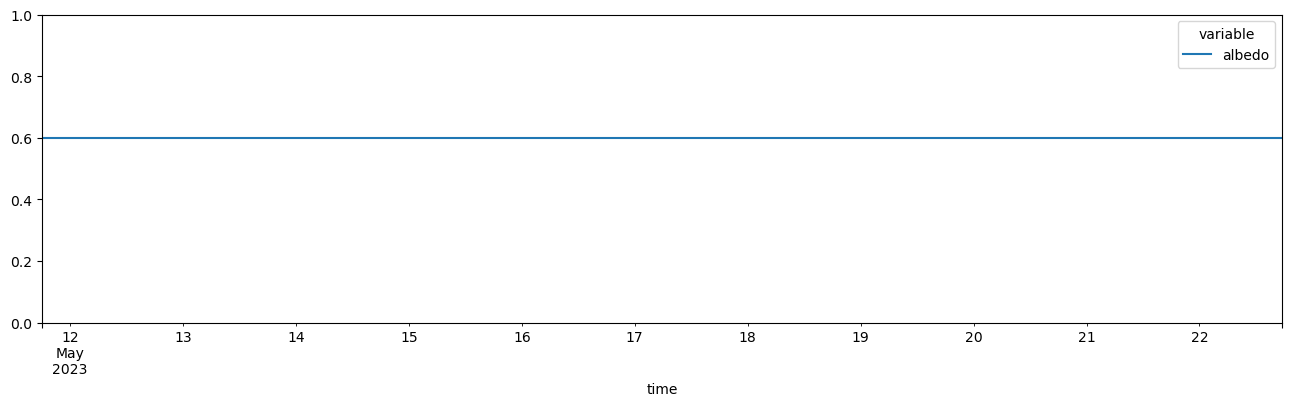

In [39]:
net_rad_df[['albedo']].plot(figsize=(16,4))
plt.ylim(0,1)

Turbulent fluxes

In [40]:
turb_flux_df = sos_df[sos_df.variable.isin([
    'w_h2o__3m_c',
    'w_tc__3m_c'
])].pivot_table(index='time', columns='variable', values='value')

latent_heat_sublimation = 2838 #J/g
turb_flux_df['w_h2o__3m_c'] = - turb_flux_df['w_h2o__3m_c'] * latent_heat_sublimation

specific_heat_capacity_air = 1.005 # J/K/g
air_density = 1000 # g/m^3                                       
turb_flux_df['w_tc__3m_c'] = - turb_flux_df['w_tc__3m_c'] * specific_heat_capacity_air * air_density

turb_flux_df.head(3)

variable             w_h2o__3m_c  w_tc__3m_c
time                                        
2022-10-31 18:00:00    -7.737561   26.781283
2022-10-31 18:30:00    -8.103559   26.646656
2022-10-31 19:00:00    -5.446743   24.788923

temperature (heat) storage change

In [41]:
heat_storage_df = sos_df[sos_df.variable.isin([
    'T_2m_c',
])].pivot_table(index='time', columns='variable', values='value')
heat_storage_df['dT_dt'] = heat_storage_df['T_2m_c'].diff() / (30*60)
heat_storage_df['dT_dt_integrated'] = heat_storage_df['dT_dt']*2
heat_storage_df['storage change'] = heat_storage_df['dT_dt_integrated'] * specific_heat_capacity_air * air_density

<Axes: xlabel='time'>

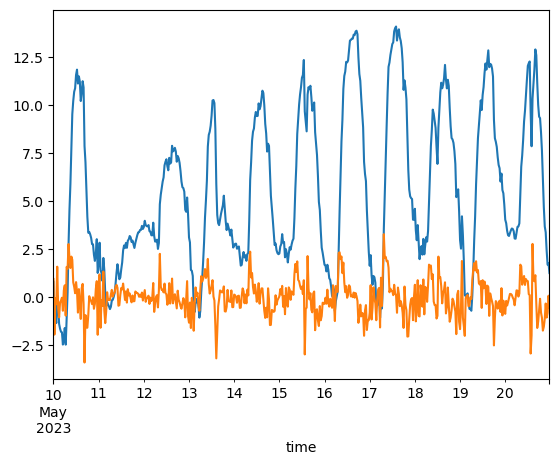

In [42]:
heat_storage_df['T_2m_c'].loc['20230510': '20230520'].plot()
heat_storage_df['storage change'].loc['20230510': '20230520'].plot()

Melt energy

In [43]:
melt_energy_df = sos_df[sos_df.variable.isin([
    'SnowDepth_c', 'SnowDepth_d', 
    'SWE_p2_c', 'SWE_p4_c', 
])].set_index('time').sort_index().loc[
    '20230512': '20230518'
].reset_index().pivot_table(
    index = ['time', 'tower'],
    values='value',
    columns='measurement'
).reset_index()

melt_energy_df.head(3)

measurement                time tower         SWE  snow depth
0           2023-05-12 00:00:00     c   94.376358    0.217653
1           2023-05-12 00:00:00     d  264.106995    0.276317
2           2023-05-12 00:30:00     c   94.313995    0.217298

In [44]:
melt_energy_df_c = melt_energy_df.query("tower == 'c'")
melt_energy_df_d = melt_energy_df.query("tower == 'd'")

Examine snow depth data, and what if we apply a rolling median

<Axes: >

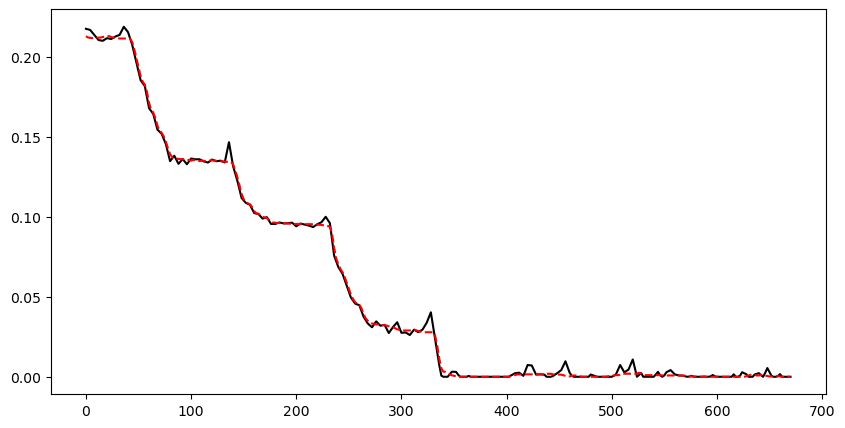

In [45]:
plt.subplots(figsize=(10,5))
melt_energy_df_c['snow depth'].plot(color='black')
melt_energy_df_c['snow depth'].rolling(20, center=True, min_periods=1).median().plot(color='red', linestyle='--')

Yeah, it looks like we should apply the rolling median

In [46]:
melt_energy_df_c['snow depth'] = melt_energy_df_c['snow depth'].rolling(20, center=True, min_periods=1).median()
melt_energy_df_d['snow depth'] = melt_energy_df_d['snow depth'].rolling(20, center=True, min_periods=1).median()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30802/2431394897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melt_energy_df_c['snow depth'] = melt_energy_df_c['snow depth'].rolling(20, center=True, min_periods=1).median()
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30802/2431394897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melt_energy_df_d['snow depth'] = melt_energy_df_d['snow depth'].rolling(20, center=True, min_periods=1).median()


In [47]:
# DO CALCS FOR TOWER D
# Calculate the snow melt rate
# divide by 30*60 to get m per second
snow_melt_m_per_s_c = melt_energy_df_c['snow depth'].diff() / (30*60)
snow_melt_m_per_s_d = melt_energy_df_d['snow depth'].diff() / (30*60)

In [48]:
snow_density = 430 * units("kg/m^3")
specific_heat_of_fusion = 334 * units("kJ/kg")
display(snow_density)
display(specific_heat_of_fusion)

<Quantity(430.0, 'kilogram / meter ** 3')>

<Quantity(334.0, 'kilojoule / kilogram')>

In [49]:
melt_energy_c = (   
    (
        snow_melt_m_per_s_c.values * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")
melt_energy_d = (   
    (
        snow_melt_m_per_s_d.values * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")

In [50]:
melt_energy_df_c = melt_energy_df_c.assign(melt_energy_c  = melt_energy_c).set_index('time')
melt_energy_df_d = melt_energy_df_d.assign(melt_energy_d  = melt_energy_d).set_index('time')

<Axes: xlabel='time'>

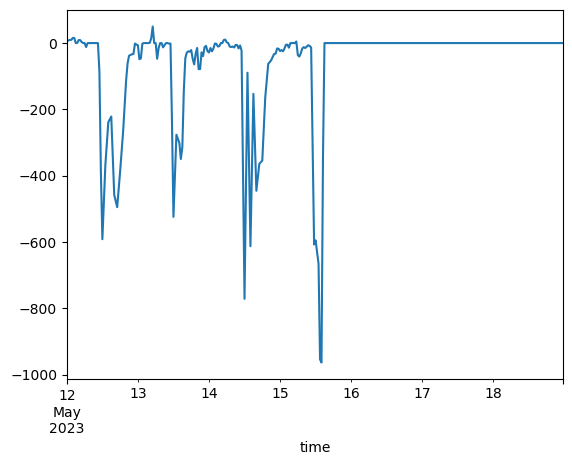

In [51]:
melt_energy_df_d['melt_energy_d'].plot()

In [52]:
energy_balance_df = turb_flux_df.join(
    net_rad_df
).join(
    melt_energy_df_c[['melt_energy_c']]
).join(
    melt_energy_df_d[['melt_energy_d']]
)
energy_balance_df.head()

w_h2o__3m_c  w_tc__3m_c  Rlw_in_9m_d  Rlw_out_9m_d  \
time                                                                      
2022-10-31 18:00:00    -7.737561   26.781283          NaN           NaN   
2022-10-31 18:30:00    -8.103559   26.646656          NaN           NaN   
2022-10-31 19:00:00    -5.446743   24.788923          NaN           NaN   
2022-10-31 19:30:00    -4.512390   22.160011          NaN           NaN   
2022-10-31 20:00:00    -0.981176   11.417387          NaN           NaN   

                     Rsw_in_9m_d  Rsw_out_9m_d  Rsw_out_9m_d_modeled  \
time                                                                   
2022-10-31 18:00:00          NaN           NaN                   NaN   
2022-10-31 18:30:00          NaN           NaN                   NaN   
2022-10-31 19:00:00          NaN           NaN                   NaN   
2022-10-31 19:30:00          NaN           NaN                   NaN   
2022-10-31 20:00:00          NaN           NaN                   NaN   

                     net radiation  albedo  melt_energy_c  melt_energy_d  
time                                                                      
2022-10-31 18:00:00            NaN     NaN            NaN            NaN  
2022-10-31 18:30:00            NaN     NaN            NaN            NaN  
2022-10-31 19:00:00            NaN     NaN            NaN            NaN  
2022-10-31 19:30:00            NaN     NaN            NaN            NaN  
2022-10-31 20:00:00            NaN     NaN            NaN            NaN

In [53]:
energy_balance_df

w_h2o__3m_c  w_tc__3m_c  Rlw_in_9m_d  Rlw_out_9m_d  \
time                                                                      
2022-10-31 18:00:00    -7.737561   26.781283          NaN           NaN   
2022-10-31 18:30:00    -8.103559   26.646656          NaN           NaN   
2022-10-31 19:00:00    -5.446743   24.788923          NaN           NaN   
2022-10-31 19:30:00    -4.512390   22.160011          NaN           NaN   
2022-10-31 20:00:00    -0.981176   11.417387          NaN           NaN   
...                          ...         ...          ...           ...   
2023-06-19 15:30:00  -492.608365 -115.190993          NaN           NaN   
2023-06-19 16:00:00  -427.559803 -101.672162          NaN           NaN   
2023-06-19 16:30:00  -378.535795  -72.942704          NaN           NaN   
2023-06-19 17:00:00  -291.586786  -45.044170          NaN           NaN   
2023-06-19 17:30:00  -229.134559  -21.224882          NaN           NaN   

                     Rsw_in_9m_d  Rsw_out_9m_d  Rsw_out_9m_d_modeled  \
time                                                                   
2022-10-31 18:00:00          NaN           NaN                   NaN   
2022-10-31 18:30:00          NaN           NaN                   NaN   
2022-10-31 19:00:00          NaN           NaN                   NaN   
2022-10-31 19:30:00          NaN           NaN                   NaN   
2022-10-31 20:00:00          NaN           NaN                   NaN   
...                          ...           ...                   ...   
2023-06-19 15:30:00          NaN           NaN                   NaN   
2023-06-19 16:00:00          NaN           NaN                   NaN   
2023-06-19 16:30:00          NaN           NaN                   NaN   
2023-06-19 17:00:00          NaN           NaN                   NaN   
2023-06-19 17:30:00          NaN           NaN                   NaN   

                     net radiation  albedo  melt_energy_c  melt_energy_d  
time                                                                      
2022-10-31 18:00:00            NaN     NaN            NaN            NaN  
2022-10-31 18:30:00            NaN     NaN            NaN            NaN  
2022-10-31 19:00:00            NaN     NaN            NaN            NaN  
2022-10-31 19:30:00            NaN     NaN            NaN            NaN  
2022-10-31 20:00:00            NaN     NaN            NaN            NaN  
...                            ...     ...            ...            ...  
2023-06-19 15:30:00            NaN     NaN            NaN            NaN  
2023-06-19 16:00:00            NaN     NaN            NaN            NaN  
2023-06-19 16:30:00            NaN     NaN            NaN            NaN  
2023-06-19 17:00:00            NaN     NaN            NaN            NaN  
2023-06-19 17:30:00            NaN     NaN            NaN            NaN  

[10253 rows x 11 columns]

In [ ]:
energy_balance_df.to_csv("energy_balance_df.csv")

# Average the melt energy across towers C and D

In [ ]:
energy_balance_df['melt_energy'] = energy_balance_df[['melt_energy_c', 'melt_energy_d']].mean(axis=1)

In [ ]:
fig, ax = plt.subplots()
energy_balance_df[[
    'w_h2o__3m_c', 'w_tc__3m_c', 'net radiation', 'melt_energy'
]].loc[
    '20230512': '20230516'
].plot(ax=ax)
pd.DataFrame(energy_balance_df[[
    'w_h2o__3m_c', 'w_tc__3m_c', 'net radiation', 'melt_energy'
]].sum(axis=1).rename('residual')).loc[
    '20230512': '20230516'
].plot(color='black', alpha=0.5, ax=ax)

In [ ]:
alt_default_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]

In [ ]:
src = energy_balance_df[[
    'w_h2o__3m_c', 'w_tc__3m_c', 'net radiation', 'melt_energy'
]].loc['20230512': '20230514']
src['residual'] = energy_balance_df[[
    'w_h2o__3m_c', 'w_tc__3m_c', 'net radiation', 'melt_energy'
]].sum(axis=1)
alt.Chart(src.reset_index()).transform_fold(
    src.columns
).mark_line().transform_window(
    rolling_avg = 'mean(value)',
    frame=[-2,2],
    groupby = ['key']
).encode(
    alt.X('time:T'),
    alt.Y('rolling_avg:Q'),
    alt.Color('key:N').scale(
        domain=['residual', 'w_h2o__3m_c', 'w_tc__3m_c', 'net radiation', 'melt_energy',],
        range=['black'] + alt_default_colors
    )
).properties(width=600)

In [ ]:
src = energy_balance_df[[
    'w_h2o__3m_c', 'w_tc__3m_c', 'net radiation', 'melt_energy'
]].loc['20230512': '20230514']
src['residual'] = energy_balance_df[[
    'w_h2o__3m_c', 'w_tc__3m_c', 'net radiation', 'melt_energy'
]].sum(axis=1)
src = src[src.index.hour.isin([12,13])]
src = src.groupby(pd.Grouper(freq='1D')).mean()
src['residual'] = - src['residual']
src['melt_energy'] = - src['melt_energy']
src = src.rename(columns={
    'w_h2o__3m_c': 'Hₗ',
    'w_tc__3m_c': 'Hs',
    'melt_energy': 'Eₘₑₗₜ',
    'net radiation': 'Rₙ',
    'residual': 'Res'

})
src = src.melt(ignore_index=False).reset_index()
alt.Chart(src).transform_calculate(
    is_melt_energy = "datum.variable == 'Eₘₑₗₜ'"
).mark_bar().encode(
    alt.Color('variable:N').sort(['Rₙ', 'Eₘₑₗₜ', 'Hₗ', 'Hs', 'Res']).scale(
        domain=['Rₙ', 'Eₘₑₗₜ', 'Hₗ', 'Hs', 'Res'],
        range=['#ff7f0e', '#1f77b4', '#17becf', '#d62728', 'darkgrey']
    ),
    alt.X('is_melt_energy:O').axis(None),
    alt.Y('value:Q'),
    alt.Facet('time:O'),
)

# Modeling 

## Height of the internal boundary layer

$$ B = c X_s^b $$

In [ ]:
# def ibl_height(X, c = 0.23, b=0.58):
def ibl_height(X, c = 0.135, b=0.6):
    return c*X**b + 0.2

ds_1frame_cropped.plot(vmin=0,vmax=15, cmap='turbo', figsize=(10,4), add_colorbar=False)
plt.plot(
    np.linspace(0,40, 100),
    ibl_height(np.linspace(0,40, 100),)
    
)
# plt.gca().set_aspect('equal')
plt.xlim(0,40)
plt.axhline(0.2)

We will model the profiles at just one point in time

In [ ]:
sos_data_moment = sos_df.set_index('time').loc['20230517 1200']

Set constants

In [ ]:
k = 0.41
rho    = 1.225 * units("kg/m^3")     # density of air
c_p    = 1005  * units("J/(kg*K)")    # specific heat of dry air

## Advected Energy - Profiles

First let's solve for $\Delta S_H$
$$ \Delta S_H = U_s T(z)_s - U_u T(z)_u$$

$$T_z = T_s + \frac{T_*}{k} \text{ln} \frac{z}{z_0}$$

$$T_* = \frac{H}{\rho C_p U_*}$$

W will estimate the $T(z)$ profiles over the (upwind) ground surface and over the (downwind) snow surface. 

### Temperature Profile over Ground

$T(z)_{ground}$

$$T_z = T_s + \frac{H}{k \rho C_p U_*} \text{ln} \frac{z}{z_0}$$


We have every term above known, except for z_0. Let's fit for z_0

In [ ]:
T_z_ground = (sos_data_moment.query("variable== 'T_2m_c'").iloc[0].value *  units("degC")).to(
    units("kelvin")
)
T_s_ground = (sos_data_moment.query("variable== 'Tsurf_c'").iloc[0].value *  units("degC")).to(
    units("kelvin")
)
H_ground = rho * c_p * (
    sos_data_moment.query("variable== 'w_tc__2m_c'").iloc[0].value * units("kelvin * m/s")
)   
U_star_ground = sos_data_moment.query("variable== 'u*_2m_c'").iloc[0].value *  units("m/s")
z = 2 * units("meters")


Solve for z_0

$$
z_0 = z \space \text{exp} \Bigg[- \frac{k \rho C_p U_*} {H}(T_z - T_s) \Bigg] 

$$

In [ ]:
z_0 = z*np.exp(
    - (
        (-k*rho*c_p*U_star_ground) / H_ground
    ) * (
        T_z_ground - T_s_ground
    )
)
z_0

And now estimate the full profile for a range $z$ between 0 and 3 m

In [ ]:
def get_T_z_ground(z):
    z = z * units("meters")
    return (T_s_ground + (
        H_ground / (-k*rho*c_p*U_star_ground)
    ) * np.log(
        z / z_0
    )).to(units("degC")).magnitude

In [ ]:
T_df = pd.DataFrame(pd.Series(np.linspace(0,2,100)).rename('z'))
T_df = T_df.assign(
    T_ground = T_df.z.apply(get_T_z_ground)
)
T_df.loc[0, 'T_ground'] = T_s_ground.to(units("degC")).magnitude
modeled_ground_t_prof_chart = alt.Chart(T_df).mark_line(color='red', opacity=0.5).encode(
    x='T_ground:Q',
    y='z:Q',
    order='z:Q'
)
modeled_ground_t_prof_chart + (
    ir_chart + surf_t_chart +  snow_t_chart + air_t_chart + sonic_t_chart
)

### Temperature Profile over Snow

$T(z)_{snow}$

Repeat what we did above for $T(z)_{ground}$, let's look at the equation again...

$$T_z = T_s + \frac{H}{k \rho C_p U_*} \text{ln} \frac{z}{z_0}$$

This time, we don't know H. So we will assume a value of z_0 for snow, and solve for H - then we can estimate the full $T(z)$. We could try to solve for H, but I only know how to do so if we use MOST - but that doesn't work here because we KNOW there is no constant flux layer over the snow. So let's solve for $H$.

$$ H = k \rho C_p U_* \Bigg[ \frac{T_z - T_s}{\text{ln} \frac{z}{z_0}} \Bigg] $$

In [ ]:
U_star_snow = U_star_ground
z_0_snow = 0.0002 * units("meters")
T_z_snow = (sos_data_moment.query("variable== 'T_2m_c'").iloc[0].value *  units("degC")).to(
    units("kelvin")
)
T_s_snow = (sos_data_moment.query("variable== 'Tsurf_uw'").iloc[0].value *  units("degC")).to(
    units("kelvin")
)
print(T_z_snow, T_s_snow)

In [ ]:
H_snow = k*rho*c_p*U_star_snow * (
    (T_z_snow - T_s_snow) / np.log(z/z_0_snow)
)
H_snow

WHY IS THIS POSITIVE? Let's just force it to be negative for now.

In [ ]:
H_snow = - H_snow
H_snow

And now estimate the full profile for a range $z$ between 0 and 3 m

In [ ]:
def get_T_z_snow(z):
    z = z * units("meters")
    return (T_s_snow + (
        H_snow / (-k*rho*c_p*U_star_snow)
    ) * np.log(
        z / z_0_snow
    )).to(units("degC")).magnitude

In [ ]:
T_df = T_df.assign(
    T_snow = T_df.z.apply(get_T_z_snow)
)
T_df.loc[0, 'T_snow'] = T_s_snow.to(units("degC")).magnitude
modeled_snow_t_prof_chart = alt.Chart(T_df).mark_line(color='red', opacity=0.5).encode(
    x='T_snow:Q',
    y='z:Q',
    order='z:Q'
)
(modeled_snow_t_prof_chart + modeled_ground_t_prof_chart + (
    ir_chart + surf_t_chart +  snow_t_chart + air_t_chart
)).properties(width=600)

### Humidity Profile over Ground 

$\rho_v(z)_{ground}$


$$\rho_{v,z} = \rho_{v,s} + \frac{E}{k \lambda_s U_*} \text{ln} \frac{z}{z_0}$$

We have every term above known, except for z_0. Let's solve for z_0

$$
z_0 = z \space \text{exp} \Bigg[- \frac{k \lambda_s U_*} {E}(\rho_{v,z} - \rho_{v,s}) \Bigg] 

$$

Calculate absolute humidity at the snow and ground surface. Use measurements from the same towers as above - UW and C

In [ ]:
# First we calculate the mixing ratio at the surface
pressure_at_surface = calc.add_height_to_pressure(
    sos_data_moment.query("variable == 'P_10m_c'").value.iloc[0] * units("millibars"), 
    - (10*units.m)
)
sat_mixing_ratio_ground_surface = calc.saturation_mixing_ratio(
    pressure_at_surface,
    sos_data_moment.query("variable == 'Tsurf_c'").value.iloc[0] * units("degC"),
    phase='liquid'
)
# mixing ratio at cold (solid) surface beneath tower UW
sat_mixing_ratio_snow_surface = calc.saturation_mixing_ratio(
    pressure_at_surface,
    sos_data_moment.query("variable == 'Tsurf_uw'").value.iloc[0] * units("degC"),
    phase='solid'
)
# Second we calculate the dry air density at the surface
dryair_density_ground_surface = calc.density(pressure_at_surface, sos_data_moment.query("variable == 'Tsurf_c'").value.iloc[0] * units("degC"), 0)
dryair_density_snow_surface = calc.density(pressure_at_surface, sos_data_moment.query("variable == 'Tsurf_uw'").value.iloc[0] * units("degC"), 0)

# Calculate absolute humidity:
abshum_ground_surface = dryair_density_ground_surface * sat_mixing_ratio_ground_surface
abshum_snow_surface = dryair_density_snow_surface * sat_mixing_ratio_snow_surface

abshum_ground_surface, abshum_snow_surface

In [ ]:
latent_heat_of_vaporization = 2838 * units("J/g")
rhov_z_ground = (
    sos_data_moment.query("variable == 'mixingratio_2m_c'").value.iloc[0] * units("dimensionless")
 * sos_data_moment.query("variable == 'dryairdensity_2m_c'").value.iloc[0] * units("kg/meter^3")
)
rhov_s_ground = abshum_ground_surface

U_star_ground, U_star_snow

In [ ]:
rhov_s_ground, rhov_z_ground

In [ ]:
E_ground = latent_heat_of_vaporization * (
    sos_data_moment.query("variable== 'w_h2o__2m_c'").iloc[0].value * units("g/m^2/s")
)   


In [ ]:
z_0q = z*np.exp(
    - (
        (-k*latent_heat_of_vaporization*U_star_ground) / E_ground
    ) * (
        rhov_z_ground - rhov_s_ground
    )
)
z_0q

This is bad...but we will use it anyways

And now estimate the full profile for a range $z$ between 0 and 3 m

In [ ]:
def get_rhov_z_ground(z):
    z = z * units("meters")
    return (rhov_s_ground + (
        E_ground / (-k*latent_heat_of_vaporization*U_star_ground)
    ) * np.log(
        z / z_0q
    )).to(units("kg/m^3")).magnitude

In [ ]:
rhov_df = pd.DataFrame(pd.Series(np.linspace(0,2,100)).rename('z'))
rhov_df = rhov_df.assign(
    rhov_ground = rhov_df.z.apply(get_rhov_z_ground)
)

rhov_df.loc[0, 'rhov_ground'] = rhov_s_ground.magnitude
modeled_ground_rhov_prof_chart = alt.Chart(rhov_df).mark_line(color='red', opacity=0.5).encode(
    x='rhov_ground:Q',
    y='z:Q',
    order='z:Q'
)
modeled_ground_rhov_prof_chart

### Humidity Profile over Snow

$\rho_v(z)_{snow}$

Repeat what we did above for $\rho_v(z)_{ground}$, let's look at the equation again...

$$\rho_{v,z} = \rho_{v,s} + \frac{E}{k \lambda_s U_*} \text{ln} \frac{z}{z_0}$$

This time, we don't know E. So we will assume a value of z_0 for snow, and solve for E - then we can estimate the full $\rho_v(z)$. We could try to solve for E, but I only know how to do so if we use MOST - but that doesn't work here because we KNOW there is no constant flux layer over the snow. So let's solve for $E$.

$$ E =  k \lambda_s U_* \Bigg[ \frac{\rho_{v,z} -  \rho_{v,s}}{\text{ln} \frac{z}{z_0}} \Bigg] $$

In [ ]:
rhov_z_snow = rhov_z_ground
rhov_s_snow = abshum_snow_surface

In [ ]:
k*latent_heat_of_vaporization*U_star_snow

In [ ]:
E_snow = k*latent_heat_of_vaporization*U_star_snow * (
    (
        rhov_z_snow - rhov_s_snow
    ) / np.log(z/z_0_snow)
)
E_snow.to(units("W/m^2"))

WHY IS THIS NEGATIVE? Let's just force it to be positive for now.

In [ ]:
E_snow = - E_snow
E_snow.to(units("W/m^2"))

And now estimate the full profile for a range $z$ between 0 and 3 m

In [ ]:
def get_rhov_z_snow(z):
    z = z * units("meters")
    return (rhov_s_snow + (
        E_snow / (-k*latent_heat_of_vaporization*U_star_snow)
    ) * np.log(
        z / z_0_snow
    )).to(units("kg/m^3")).magnitude

In [ ]:
rhov_df = rhov_df.assign(
    rhov_snow = rhov_df.z.apply(get_rhov_z_snow)
)
rhov_df.loc[0, 'rhov_snow'] = rhov_s_snow.magnitude
modeled_snow_rhov_prof_chart = alt.Chart(rhov_df).mark_line(color='red', opacity=0.5).encode(
    x='rhov_snow:Q',
    y='z:Q',
    order='z:Q'
)
modeled_snow_rhov_prof_chart + modeled_ground_rhov_prof_chart

In [ ]:
src = sos_data_moment.query("measurement == 'Water vapor density'")
src.value = src.value / 1000
src = src.query("height <= 2")

In [ ]:
alt.Chart(
    src    
).mark_point().encode(
    alt.X('value:Q'),
    alt.Y('height'),
    alt.Shape('tower:N')
) + modeled_snow_rhov_prof_chart + modeled_ground_rhov_prof_chart

## Advected Energy - Estimates 

(Following Granger et al., 2002)
The average advected flux into the surface is the change in horizontal flux over the distance travelled:
$$ Q_a = \Delta S_h / X_s $$
where
$$  \Delta S_h = \rho c_p \int_0^B U (T_u - T_X) dz$$

Similarly for latent heat advection

$$  \Delta S_h = \lambda \int_0^B U (\rho_{v,u} - \rho_{v,X}) dz$$

In [ ]:
# THIS IS ARBITRARY
B = 2

In [ ]:
delta_S_h_sensible = rho * c_p * np.trapz(
    U * units("m/s") * (T_df['T_ground'] - T_df['T_snow']).values * units("kelvin"),
    T_df['z'].values * units("meters")
)
delta_S_h_latent = latent_heat_of_vaporization * np.trapz(
    U * units("m/s") * (rhov_df['rhov_ground'] - rhov_df['rhov_snow']).values * units("kg/m^3"),
    rhov_df['z'].values  * units("meters")
)

In [ ]:
print((delta_S_h_sensible / (10 * units("meters"))).to(units("W/m^2")))
print((delta_S_h_latent / (10 * units("meters"))).to(units("W/m^2")))

## Dimensionless horizontal stability parameter

$$ A^* = - \frac{k g z_0}{U_*^2} \frac{T_{sX} - T_{su}}{T_{su}}$$